# Preliminary operations

We import the libraries and the drive environment.

In [1]:
!pip install folium
!pip install geopandas
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 75.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 586.6 kB/s eta 0:00:00


In [2]:
# Utility
from google.colab import drive
import pandas as pd
import numpy as np
from shutil import copyfile, copy
import datetime
import urllib.request
import os
import json
import matplotlib.pyplot as plt

# Geo
import folium
import geopandas as gpd

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Input, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
import keras_tuner
from kerastuner.tuners import RandomSearch, GridSearch

seq_len = 5
n_feats = 5

<ipython-input-2-b3ec6d248bb3>:29: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, GridSearch


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
pd.set_option('display.max_columns', None)

# Loading data

In [5]:
df = pd.read_csv('/content/gdrive/MyDrive/DSLSC/motoscooter_movimento_new.csv')

In [6]:
df.columns

Index(['provider_id', 'lat', 'lng', 'created_at', 'distance', 'placename',
       'placelat', 'placelon', 'lat&lng', 'prevObservation', 'nextObservation',
       'nextCreated_at', 'nextDistance', 'nextTimeDiff', 'prevCreated_at',
       'prevDistance', 'prevTimeDiff', 'samePlace', 'type'],
      dtype='object')

In [7]:
df.created_at

0        2019-12-06 01:25:20
1        2019-12-06 01:40:22
2        2019-12-06 18:40:20
3        2019-12-06 19:40:24
4        2019-12-06 20:10:24
                ...         
82682    2019-12-07 18:55:14
82683    2019-12-07 19:10:08
82684    2019-12-08 14:25:08
82685    2019-12-08 14:40:08
82686    2019-12-08 18:40:10
Name: created_at, Length: 82687, dtype: object

In [8]:
df['created_at'] =  pd.to_datetime(df['created_at'], format = '%Y-%m-%d %H:%M:%S')
df['nextCreated_at'] =  pd.to_datetime(df['nextCreated_at'], format = '%Y-%m-%d %H:%M:%S')
df['prevCreated_at'] =  pd.to_datetime(df['prevCreated_at'], format = '%Y-%m-%d %H:%M:%S')
# Remove waiting long e-scooters
df = df[df['type'] != 'waiting long']

Now we order the dataframe by provider and we order each provider by time. This way, we will have sequences of consecutive pick-up/drop-off synchronized for each provider_id.


In [9]:
groups = df.groupby('provider_id')
ordered_df = []
for name, group in groups:
  ordered_df.append((pd.DataFrame(group)).sort_values(by = 'created_at').reset_index(drop = True))

In [10]:
combined_df = pd.concat(ordered_df)

In [11]:
combined_df.head()

,provider_id,lat,lng,created_at,distance,placename,placelat,placelon,lat&lng,prevObservation,nextObservation,nextCreated_at,nextDistance,nextTimeDiff,prevCreated_at,prevDistance,prevTimeDiff,samePlace,type
0,2.0,45.4599,9.20633,2019-12-06 01:25:20,143.437209,356.0,45.46075,9.20495,"(45.4599, 9.20633)",NaN,"(45.4622, 9.19374)",2019-12-06 01:40:22,1017.327131,15.033333,NaT,0.000000,0.000000,0.0,first seen / pick-up
1,2.0,45.4622,9.19374,2019-12-06 01:40:22,214.500848,354.0,45.46075,9.19555,"(45.4622, 9.19374)","(45.4599, 9.20633)","(45.4621, 9.19375)",2019-12-06 01:55:23,11.141565,15.016667,2019-12-06 01:25:20,1017.327131,15.033333,0.0,drop-off
2,2.0,45.4621,9.19375,2019-12-06 18:40:20,205.745441,354.0,45.46075,9.19555,"(45.4621, 9.19375)","(45.4621, 9.19375)","(45.4411, 9.18597)",2019-12-06 19:40:24,2411.994485,60.066667,2019-12-06 18:25:21,0.000000,14.983333,0.0,pick-up outlier
3,2.0,45.4411,9.18597,2019-12-06 19:40:24,95.513288,204.0,45.44195,9.18615,"(45.4411, 9.18597)","(45.4621, 9.19375)","(45.4411, 9.18597)",2019-12-06 19:55:25,0.000000,15.016667,2019-12-06 18:40:20,2411.994485,60.066667,0.0,drop-off outlier
4,2.0,45.4411,9.18597,2019-12-06 20:10:24,95.513288,204.0,45.44195,9.18615,"(45.4411, 9.18597)","(45.4411, 9.18597)","(45.4721, 9.18426)",2019-12-06 20:55:22,3447.956963,44.966667,2019-12-06 19:55:25,0.000000,14.983333,0.0,pick-up


The sorting done above allows us to correctly associate, for each sample, the pick-up points with the drop-off points.

In [12]:
pickup = ['first seen / pick-up', 'pick-up', 'pick-up outlier']
dropoff = ['last seen / drop-off', 'drop-off', 'drop-off outlier']
# Create 2 different dataframes: one for pick-up and one for drop-off
df_p = combined_df[combined_df['type'].isin(pickup)]
df_d = combined_df[combined_df['type'].isin(dropoff)]

The 2 dataframes are ordered by provider_id and each provider_id is ordered by time. They are syncrhonized, so that for example the first row is both the pick-up point and the drop-off point of the same scooter, in respectively df_p and df_d.

In [13]:
# Removing columns that aren't necessary
df_p = df_p[['provider_id', 'created_at', 'placename', 'placelon', 'placelat']].reset_index(drop = True)
df_d = df_d[['created_at', 'placename', 'placelon', 'placelat']].reset_index(drop = True)

# The placename and the coordinates of the drop-off observation are our target
df_p['target'] = df_d['placename']
df_p['target_lon'] = df_d['placelon']
df_p['target_lat'] = df_d['placelat']
df = df_p.copy()

We also may create a variable indicating if it's saturday or sunday.

In [14]:
df['is_weekend'] = df['created_at'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

In [15]:
df.head()

,provider_id,created_at,placename,placelon,placelat,target,target_lon,target_lat,is_weekend
0,2.0,2019-12-06 01:25:20,356.0,9.20495,45.46075,354.0,9.19555,45.46075,0
1,2.0,2019-12-06 18:40:20,354.0,9.19555,45.46075,204.0,9.18615,45.44195,0
2,2.0,2019-12-06 20:10:24,204.0,9.18615,45.44195,426.0,9.18615,45.47015,0
3,2.0,2019-12-07 00:25:20,426.0,9.18615,45.47015,503.0,9.20025,45.47955,1
4,2.0,2019-12-07 08:40:16,503.0,9.20025,45.47955,503.0,9.20025,45.47955,1


# Zone prediction \#1 (5 e-scooters)

The goal of this task is to build a prediction model in order to know in advance the drop-off zone of each specific scooter (with probability attached) so that I know where to pick it up. Here we perform a classification task on 12 rectangular zones of Milan, i.e. with a medium level of granularity.

## Pre-processing

In [16]:
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = gpd.points_from_xy(df.placelon, df.placelat))

In [17]:
milan_nil = gpd.read_file("/content/gdrive/MyDrive/DSLSC/NIL_E0.zip")

In [18]:
# Ensuring the crs is the same
if gdf.crs != milan_nil.crs:
  milan_nil = milan_nil.to_crs(gdf.crs)

In [19]:
# Spatial join between the zones and scooters GeoDataFrames
zones_with_scooters_gdf = gpd.sjoin(milan_nil, gdf, predicate = 'contains')
# Group the GeoDataFrame by zone ID and count the number of scooters in each zone
scooter_counts_by_zone = zones_with_scooters_gdf.groupby('NIL').size()
# Get the IDs of the zones with scooters
zones_with_scooters_ids = scooter_counts_by_zone.index
# Filter the zones GeoDataFrame in order to remove the zones without scooters
zones_gdf = milan_nil[milan_nil['NIL'].isin(zones_with_scooters_ids)]
zones_gdf = zones_gdf.reset_index(drop = True)

In [20]:
zones_gdf['City'] = 'Milan'
city = zones_gdf.to_crs(epsg = 4326).dissolve(by = 'City')

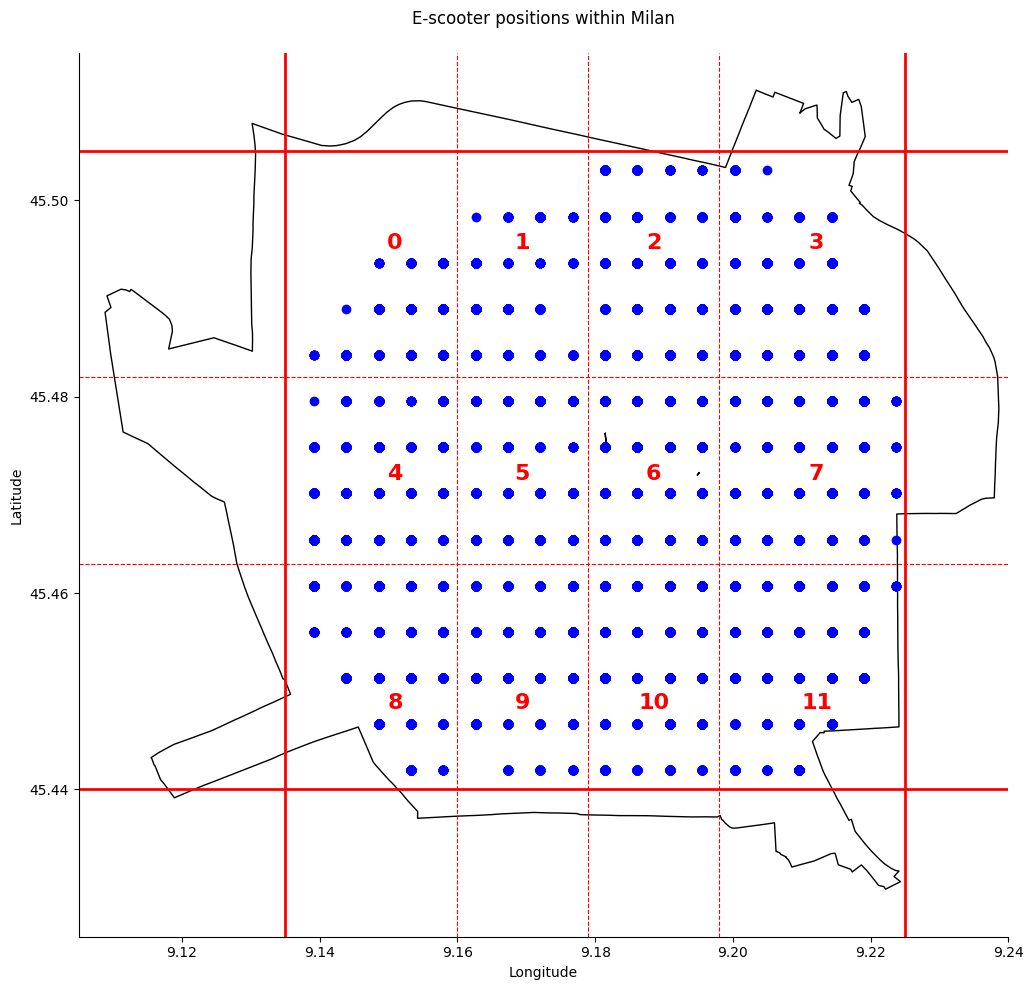

In [21]:
# Plot the quarters polygons
ax = city.plot(edgecolor = 'k', facecolor = 'none', figsize = (15, 10))
gdf.plot(ax = ax, color = "blue")
ax.set_title('E-scooter positions within Milan\n')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.annotate('0', (9.1498, 45.495), color = 'red', fontsize = 16, weight = 'bold')
ax.annotate('1', (9.1683, 45.495), color = 'red', fontsize = 16, weight = 'bold')
ax.annotate('2', (9.1874, 45.495), color = 'red', fontsize = 16, weight = 'bold')
ax.annotate('3', (9.211, 45.495), color = 'red', fontsize = 16, weight = 'bold')
ax.annotate('4', (9.1498, 45.4715), color = 'red', fontsize = 16, weight = 'bold')
ax.annotate('5', (9.1683, 45.4715), color = 'red', fontsize = 16, weight = 'bold')
ax.annotate('6', (9.1874, 45.4715), color = 'red', fontsize = 16, weight = 'bold')
ax.annotate('7', (9.211, 45.4715), color = 'red', fontsize = 16, weight = 'bold')
ax.annotate('8', (9.1498, 45.4482), color = 'red', fontsize = 16, weight = 'bold')
ax.annotate('9', (9.1683, 45.4482), color = 'red', fontsize = 16, weight = 'bold')
ax.annotate('10', (9.1863, 45.4482), color = 'red', fontsize = 16, weight = 'bold')
ax.annotate('11', (9.21, 45.4482), color = 'red', fontsize = 16, weight = 'bold')

ax.axhline(y = 45.505, color = 'red', linewidth = 2)
ax.axhline(y = 45.44, color = 'red', linewidth = 2)
ax.axvline(x = 9.135, color = 'red', linewidth = 2)
ax.axvline(x = 9.225, color = 'red', linewidth = 2)

ax.axhline(y = 45.482, color = 'red', linestyle = '--', linewidth = 0.8)
ax.axhline(y = 45.463, color = 'red', linestyle = '--', linewidth = 0.8)
ax.axvline(x = 9.160, color = 'red', linestyle = '--', linewidth = 0.8)
ax.axvline(x = 9.179, color = 'red', linestyle = '--', linewidth = 0.8)
ax.axvline(x = 9.198, color = 'red', linestyle = '--', linewidth = 0.8)

# Set the axis limits
ax.set_xlim(9.105, 9.24)
ax.set_ylim(45.425, 45.515)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('Milan zones.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
for i in range(0, len(gdf)):
  if(9.13 <= gdf['target_lon'][i] <= 9.16):
    # Zone 0
    if(45.482 <= gdf['target_lat'][i] <= 45.505):
      gdf['target'][i] = 0
    # Zone 1
    if(45.463 <= gdf['target_lat'][i] < 45.482):
      gdf['target'][i] = 1
    # Zone 2
    if(45.44 <= gdf['target_lat'][i] < 45.463):
      gdf['target'][i] = 2
  if(9.16 < gdf['target_lon'][i] <= 9.179):
    # Zone 3
    if(45.482 <= gdf['target_lat'][i] <= 45.505):
      gdf['target'][i] = 3
    # Zone 4
    if(45.463 <= gdf['target_lat'][i] < 45.482):
      gdf['target'][i] = 4
    # Zone 5
    if(45.44 <= gdf['target_lat'][i] < 45.463):
      gdf['target'][i] = 5
  if(9.179 < gdf['target_lon'][i] <= 9.198):
    # Zone 6
    if(45.482 <= gdf['target_lat'][i] <= 45.505):
      gdf['target'][i] = 6
    # Zone 7
    if(45.463 <= gdf['target_lat'][i] < 45.482):
      gdf['target'][i] = 7
    # Zone 8
    if(45.44 <= gdf['target_lat'][i] < 45.463):
      gdf['target'][i] = 8
  if(9.198 < gdf['target_lon'][i] <= 9.24):
    # Zone 9
    if(45.482 <= gdf['target_lat'][i] <= 45.505):
      gdf['target'][i] = 9
    # Zone 10
    if(45.463 <= gdf['target_lat'][i] < 45.482):
      gdf['target'][i] = 10
    # Zone 11
    if(45.44 <= gdf['target_lat'][i] < 45.463):
      gdf['target'][i] = 11

In [23]:
df = gdf[['provider_id', 'created_at', 'placelon', 'placelat', 'is_weekend', 'target']]

In [24]:
df.head()

,provider_id,created_at,placelon,placelat,is_weekend,target
0,2.0,2019-12-06 01:25:20,9.20495,45.46075,0,8.0
1,2.0,2019-12-06 18:40:20,9.19555,45.46075,0,8.0
2,2.0,2019-12-06 20:10:24,9.18615,45.44195,0,7.0
3,2.0,2019-12-07 00:25:20,9.18615,45.47015,1,10.0
4,2.0,2019-12-07 08:40:16,9.20025,45.47955,1,10.0


Now we group the dataset by target and then we order each target sequence by time.

In [25]:
# We group the dataframe by target and discard samples in a way that there are only multiple of seq_len
groups = df.groupby('target')
ordered_df = []
for name, group in groups:
  groups_2 = group.groupby('provider_id')
  for name, group_2 in groups_2:
    df_ = (pd.DataFrame(group_2)).sort_values(by = 'created_at').reset_index(drop = True)
    if(len(group)%seq_len == 0):
      ordered_df.append(df_)
    else:
      df_ = df_[:-((len(df_))%seq_len)]
      ordered_df.append(df_)

In [26]:
combined_df = pd.concat(ordered_df)

In [28]:
df = combined_df.reset_index(drop = True)

In [30]:
df

,provider_id,created_at,placelon,placelat,is_weekend,target
0,909.0,2019-12-07 01:40:09,9.14855,45.46075,1,0.0
1,909.0,2019-12-07 01:55:26,9.15325,45.48895,1,0.0
2,909.0,2019-12-07 02:25:27,9.15325,45.48895,1,0.0
3,909.0,2019-12-07 02:55:29,9.15325,45.48895,1,0.0
4,909.0,2019-12-07 05:10:30,9.15325,45.48895,1,0.0
...,...,...,...,...,...,...
24825,1751.0,2019-12-06 09:40:12,9.21435,45.48895,0,11.0
24826,1751.0,2019-12-06 14:55:17,9.20495,45.47485,0,11.0
24827,1751.0,2019-12-06 18:56:16,9.20495,45.45135,0,11.0
24828,1751.0,2019-12-08 00:55:17,9.20495,45.45135,1,11.0


## Preparation

In [ ]:
encoder_id = LabelEncoder()
df['provider_id'] = encoder_id.fit_transform(df['provider_id'])

In [ ]:
# Converting datetime in unixtime (int)
dates = pd.to_datetime(df['created_at'])
df['created_at'] = dates.astype(np.int64) // 10**9
min_time = min(df['created_at'])
df['created_at'] = df['created_at'] - min_time
#df['created_at'] = df['created_at'] % 86400

In [ ]:
# Test-set = monday
test = df[df['created_at'] < 1575331200 - min_time]
train = df.drop(test.index)
test.reset_index(drop = True, inplace = True)
train.reset_index(drop = True, inplace = True)

In [ ]:
max_test = max(test['created_at'])
train['created_at'] = train['created_at'] - max_test
max_train = max(train['created_at'])
test['created_at'] = test['created_at'] + max_train

In [ ]:
train_test_ordered = pd.concat([train, test], ignore_index = True)

Now we create the validation set, selecting the last 30% of each target. Moreover, we save the array with training + validation for further retraining.

In [ ]:
X = train.copy(deep = True)

In [ ]:
val = pd.DataFrame(columns = train.columns)

for i in range(0, 12):
  sub = train[train['target'] == i]
  for j in sub['provider_id'].unique():
    to_pick = int((len(sub[sub['provider_id'] == j]))*0.3)
    rows = sub[sub['provider_id'] == j].tail(to_pick)
    train = train.drop(rows.index)
    val = pd.concat([val, rows], ignore_index = True)

train.reset_index(drop = True, inplace = True)

In [ ]:
scaler_0 = MinMaxScaler()
scaler_1 = MinMaxScaler()
scaler_2 = MinMaxScaler()
scaler_3 = MinMaxScaler()

df['provider_id'] = scaler_0.fit_transform(np.array(df['provider_id']).reshape(-1, 1))
train_test_ordered['created_at'] = scaler_1.fit_transform(np.array(train_test_ordered['created_at']).reshape(-1, 1))

X['provider_id'] = scaler_0.transform(np.array(X['provider_id']).reshape(-1, 1))
X['created_at'] = scaler_1.transform(np.array(X['created_at']).reshape(-1, 1))
X['placelon'] = scaler_2.fit_transform(np.array(X['placelon']).reshape(-1, 1))
X['placelat'] = scaler_3.fit_transform(np.array(X['placelat']).reshape(-1, 1))

train['provider_id'] = scaler_0.transform(np.array(train['provider_id']).reshape(-1, 1))
train['created_at'] = scaler_1.transform(np.array(train['created_at']).reshape(-1, 1))
train['placelon'] = scaler_2.transform(np.array(train['placelon']).reshape(-1, 1))
train['placelat'] = scaler_3.transform(np.array(train['placelat']).reshape(-1, 1))

val['provider_id'] = scaler_0.transform(np.array(val['provider_id']).reshape(-1, 1))
val['created_at'] = scaler_1.transform(np.array(val['created_at']).reshape(-1, 1))
val['placelon'] = scaler_2.transform(np.array(val['placelon']).reshape(-1, 1))
val['placelat'] = scaler_3.transform(np.array(val['placelat']).reshape(-1, 1))

test['provider_id'] = scaler_0.transform(np.array(test['provider_id']).reshape(-1, 1))
test['created_at'] = scaler_1.transform(np.array(test['created_at']).reshape(-1, 1))
test['placelon'] = scaler_2.transform(np.array(test['placelon']).reshape(-1, 1))
test['placelat'] = scaler_3.transform(np.array(test['placelat']).reshape(-1, 1))

In [ ]:
# Now we have to fix the lengths of train, val and test, in the same way as before
groups = train.groupby('target')
ordered_df_train = []
for name, group in groups:
  groups_2 = group.groupby('provider_id')
  for name, group_2 in groups_2:
    df_ = (pd.DataFrame(group_2)).sort_values(by = 'created_at').reset_index(drop = True)
    if(len(group_2)%seq_len != 0):
      df_ = df_[:-((len(df_))%seq_len)]
    ordered_df_train.append(df_)

groups = val.groupby('target')
ordered_df_val = []
for name, group in groups:
  groups_2 = group.groupby('provider_id')
  for name, group_2 in groups_2:
    df_ = (pd.DataFrame(group_2)).sort_values(by = 'created_at').reset_index(drop = True)
    if(len(group_2)%seq_len != 0):
      df_ = df_[:-((len(df_))%seq_len)]
    ordered_df_val.append(df_)
    
groups = test.groupby('target')
ordered_df_test = []
for name, group in groups:
  groups_2 = group.groupby('provider_id')
  for name, group_2 in groups_2:
    df_ = (pd.DataFrame(group_2)).sort_values(by = 'created_at').reset_index(drop = True)
    if(len(group_2)%seq_len != 0):
      df_ = df_[:-((len(df_))%seq_len)]
    ordered_df_test.append(df_)

# Training + validation
groups = X.groupby('target')
ordered_df_X = []
for name, group in groups:
  groups_2 = group.groupby('provider_id')
  for name, group_2 in groups_2:
    df_ = (pd.DataFrame(group_2)).sort_values(by = 'created_at').reset_index(drop = True)
    if(len(group_2)%seq_len != 0):
      df_ = df_[:-((len(df_))%seq_len)]
    ordered_df_X.append(df_)

In [ ]:
train = pd.concat(ordered_df_train).reset_index(drop = True)
val = pd.concat(ordered_df_val).reset_index(drop = True)
test = pd.concat(ordered_df_test).reset_index(drop = True)
X = pd.concat(ordered_df_X).reset_index(drop = True)

In [ ]:
train

,provider_id,created_at,placelon,placelat,is_weekend,target
0,0.433202,0.541108,0.055556,0.615385,0,0.0
1,0.433202,0.562031,0.222222,0.692308,0,0.0
2,0.433202,0.565014,0.222222,0.692308,0,0.0
3,0.433202,0.568003,0.222222,0.692308,0,0.0
4,0.433202,0.573990,0.222222,0.692308,1,0.0
...,...,...,...,...,...,...
9810,0.995088,0.295963,0.833333,0.000000,0,11.0
9811,0.995088,0.301929,0.833333,0.000000,0,11.0
9812,0.995088,0.307912,0.833333,0.000000,0,11.0
9813,0.995088,0.309405,0.833333,0.000000,0,11.0


In [ ]:
val

,provider_id,created_at,placelon,placelat,is_weekend,target
0,0.433202,0.633774,0.222222,0.692308,1,0.0
1,0.433202,0.635265,0.222222,0.692308,1,0.0
2,0.433202,0.639751,0.222222,0.692308,1,0.0
3,0.433202,0.642739,0.222222,0.692308,1,0.0
4,0.433202,0.645731,0.222222,0.692308,1,0.0
...,...,...,...,...,...,...
1925,0.995088,0.382646,0.833333,0.230769,0,11.0
1926,0.995088,0.394597,0.888889,0.230769,0,11.0
1927,0.995088,0.434969,0.777778,0.000000,0,11.0
1928,0.995088,0.436464,0.777778,0.000000,0,11.0


In [ ]:
test

,provider_id,created_at,placelon,placelat,is_weekend,target
0,0.463654,0.938687,0.722222,0.000000,0,0.0
1,0.463654,0.943202,0.166667,0.769231,0,0.0
2,0.463654,0.946179,0.166667,0.769231,0,0.0
3,0.463654,0.949175,0.111111,0.769231,0,0.0
4,0.463654,0.955150,0.111111,0.769231,0,0.0
...,...,...,...,...,...,...
1955,0.984283,0.874409,0.944444,0.153846,0,11.0
1956,0.984283,0.880386,0.944444,0.153846,0,11.0
1957,0.984283,0.881884,0.944444,0.153846,0,11.0
1958,0.984283,0.898321,0.944444,0.153846,0,11.0


In [ ]:
X

,provider_id,created_at,placelon,placelat,is_weekend,target
0,0.432220,0.582920,0.111111,0.307692,1,0.0
1,0.432220,0.584443,0.166667,0.769231,1,0.0
2,0.432220,0.587434,0.166667,0.769231,1,0.0
3,0.432220,0.590427,0.166667,0.769231,1,0.0
4,0.432220,0.603880,0.166667,0.769231,1,0.0
...,...,...,...,...,...,...
17505,0.997053,0.487266,0.888889,0.769231,0,11.0
17506,0.997053,0.518663,0.777778,0.538462,0,11.0
17507,0.997053,0.542675,0.777778,0.153846,0,11.0
17508,0.997053,0.721938,0.777778,0.153846,1,11.0


In [ ]:
X_train = np.array((train[['provider_id', 'created_at', 'placelon', 'placelat', 'is_weekend']])).reshape(-1, seq_len, n_feats)
y_train = np.array((train['target'])).reshape(-1, seq_len)

X_val = np.array((val[['provider_id', 'created_at', 'placelon', 'placelat', 'is_weekend']])).reshape(-1, seq_len, n_feats)
y_val = np.array((val['target'])).reshape(-1, seq_len)

X_test = np.array((test[['provider_id', 'created_at', 'placelon', 'placelat', 'is_weekend']])).reshape(-1, seq_len, n_feats)
y_test = np.array((test['target'])).reshape(-1, seq_len)

y = np.array((X['target'])).reshape(-1, seq_len)
X = np.array((X[['provider_id', 'created_at', 'placelon', 'placelat', 'is_weekend']])).reshape(-1, seq_len, n_feats)

In [ ]:
y_train = to_categorical(y_train)[:, 0, :]
y_val = to_categorical(y_val)[:, 0, :]
y_test = to_categorical(y_test)[:, 0, :]
y = to_categorical(y)[:, 0, :]

In [ ]:
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)
print(X.shape)
print(y.shape)

(1963, 5, 5)
(1963, 12)
(386, 5, 5)
(386, 12)
(392, 5, 5)
(392, 12)
(3502, 5, 5)
(3502, 12)


## Model selection

We use a RNN LSTM for this task. In this section we start from a basic network and select the best model iteratively.

### Model 0

In [ ]:
model0 = Sequential()
model0.add(LSTM(16, input_shape = (seq_len, n_feats), return_sequences = True))
model0.add(LSTM(32, return_sequences = False))
model0.add(Dense(32))
model0.add(Dense(12, activation = 'softmax'))
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 16)             1408      
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 12)                396       
                                                                 
Total params: 9,132
Trainable params: 9,132
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = Adam(learning_rate = 0.0001)
model0.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history0 = model0.fit(X_train, y_train, epochs = 100, batch_size = 16, validation_data = (X_val, y_val))

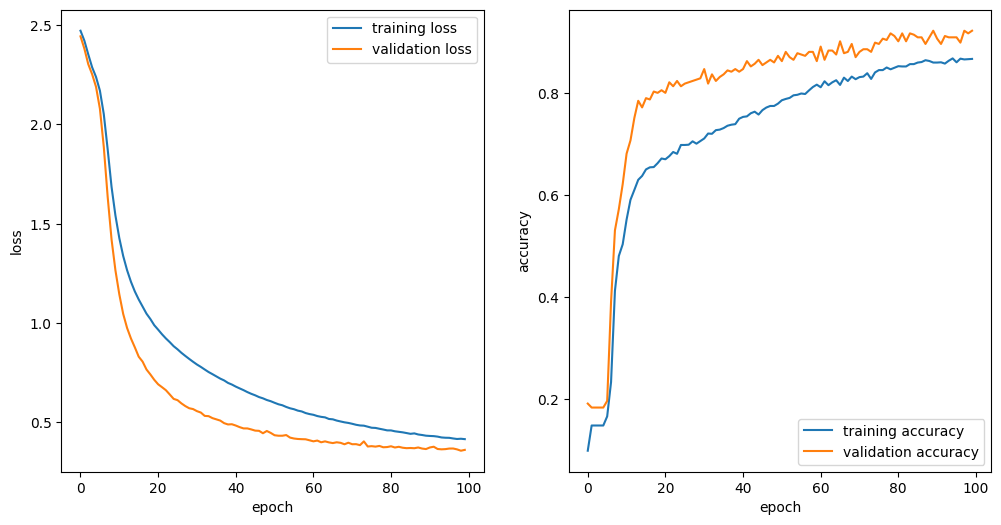

In [ ]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history0.history['loss'])
plt.plot(history0.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1, 2, 2)
plt.plot(history0.history['accuracy'])
plt.plot(history0.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

Now retrain on training + validation and save the model.

In [ ]:
model0 = Sequential()
model0.add(LSTM(16, input_shape = (seq_len, n_feats), return_sequences = True))
model0.add(LSTM(32, return_sequences = False))
model0.add(Dense(32))
model0.add(Dense(12, activation = 'softmax'))

In [ ]:
optimizer = Adam(learning_rate = 0.0001)
model0.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history0 = model0.fit(X, y, epochs = 100, batch_size = 16)

Epoch 1/100
219/219 [==============================] - 4s 4ms/step - loss: 2.4434 - accuracy: 0.1493
Epoch 2/100
219/219 [==============================] - 1s 5ms/step - loss: 2.3566 - accuracy: 0.1688
Epoch 3/100
219/219 [==============================] - 1s 5ms/step - loss: 2.2064 - accuracy: 0.1810
Epoch 4/100
219/219 [==============================] - 1s 5ms/step - loss: 1.9113 - accuracy: 0.2610
Epoch 5/100
219/219 [==============================] - 1s 5ms/step - loss: 1.6865 - accuracy: 0.3612
Epoch 6/100
219/219 [==============================] - 1s 5ms/step - loss: 1.5234 - accuracy: 0.4911
Epoch 7/100
219/219 [==============================] - 1s 5ms/step - loss: 1.3692 - accuracy: 0.5702
Epoch 8/100
219/219 [==============================] - 1s 4ms/step - loss: 1.2431 - accuracy: 0.6051
Epoch 9/100
219/219 [==============================] - 1s 6ms/step - loss: 1.1549 - accuracy: 0.6119
Epoch 10/100
219/219 [==============================] - 1s 7ms/step - loss: 1.0940 - accura

In [ ]:
model0.save('/content/gdrive/MyDrive/DSLSC/Models_3/Model0_5.h5')

### Keras tuner \#1

In [ ]:
#!rm -rf /content/best_hyperparams_1

Now we use the keras tuner in order to find the best units combination.

In [ ]:
# 16 different combinations
def build_model_1(hp):
  model = Sequential()
  model.add(LSTM(units = hp.Int('units_lstm_1', min_value = 16, max_value = 32, step = 16),
                  input_shape = (seq_len, n_feats),
                  return_sequences = True))
  model.add(LSTM(units = hp.Int('units_lstm_2', min_value = 32, max_value = 64, step = 32),
                  return_sequences = False))
  model.add(Dense(units = hp.Int('units_dense', min_value = 32, max_value = 64, step = 32)))
  model.add(Dense(12, activation = 'softmax'))
  
  optimizer = Adam(learning_rate = hp.Choice('learning_rate', values = [0.001, 0.0001]))
  model.compile(optimizer =  optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
tuner_1 = GridSearch(
  build_model_1,
  objective = 'val_loss',
  executions_per_trial = 1,
  directory = '/content',
  project_name = 'best_hyperparams_1'
)

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
# Grid search
tuner_1.search(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_val, y_val), callbacks = [stop_early])

In [ ]:
# Retrieve best hyperparameters and final model
best_hp = tuner_1.get_best_hyperparameters()[0]
best_model = tuner_1.hypermodel.build(best_hp)

In [ ]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 32)             4864      
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 12)                396       
                                                                 
Total params: 32,172
Trainable params: 32,172
Non-trainable params: 0
_________________________________________________________________


### Model 1

In [ ]:
model1 = Sequential()
model1.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True))
model1.add(LSTM(64, return_sequences = False))
model1.add(Dense(32))
model1.add(Dense(12, activation = 'softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             4864      
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 12)                396       
                                                                 
Total params: 32,172
Trainable params: 32,172
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model1.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history1 = model1.fit(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_val, y_val), callbacks = [stop_early])

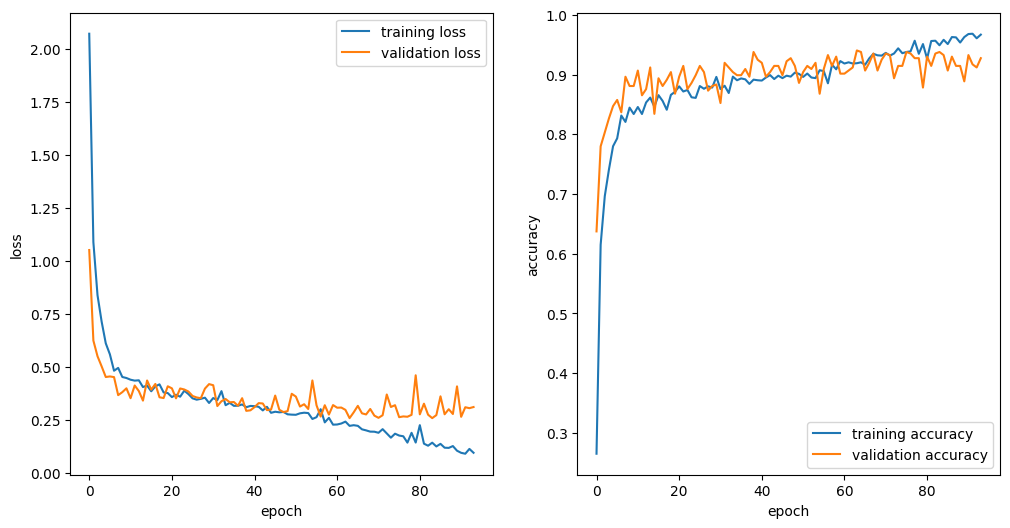

In [ ]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

Now retrain on training + validation and save the model.

In [ ]:
model1 = Sequential()
model1.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True))
model1.add(LSTM(64, return_sequences = False))
model1.add(Dense(32))
model1.add(Dense(12, activation = 'softmax'))

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model1.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history1 = model1.fit(X, y, epochs = 75, batch_size = 16)

Epoch 1/75
219/219 [==============================] - 5s 8ms/step - loss: 1.6227 - accuracy: 0.4260
Epoch 2/75
219/219 [==============================] - 2s 8ms/step - loss: 0.8759 - accuracy: 0.6768
Epoch 3/75
219/219 [==============================] - 2s 9ms/step - loss: 0.6729 - accuracy: 0.7473
Epoch 4/75
219/219 [==============================] - 3s 12ms/step - loss: 0.5810 - accuracy: 0.7824
Epoch 5/75
219/219 [==============================] - 2s 11ms/step - loss: 0.5258 - accuracy: 0.8104
Epoch 6/75
219/219 [==============================] - 2s 8ms/step - loss: 0.5047 - accuracy: 0.8070
Epoch 7/75
219/219 [==============================] - 2s 8ms/step - loss: 0.4824 - accuracy: 0.8278
Epoch 8/75
219/219 [==============================] - 2s 8ms/step - loss: 0.4862 - accuracy: 0.8252
Epoch 9/75
219/219 [==============================] - 2s 8ms/step - loss: 0.4719 - accuracy: 0.8272
Epoch 10/75
219/219 [==============================] - 2s 8ms/step - loss: 0.4371 - accuracy: 0.84

In [ ]:
model1.save('/content/gdrive/MyDrive/DSLSC//Models_3/Model1_5.h5')

### Keras tuner \#2

In [ ]:
#!rm -rf /content/best_hyperparams_2

Now we use the keras tuner in order to find the best dropout combination.

In [ ]:
# 12 different combinations
def build_model_2(hp):
  model = Sequential()
  model.add(LSTM(units = 32, input_shape = (seq_len, n_feats), return_sequences = True))
  model.add(Dropout(hp.Float('dropout_lstm_1', min_value = 0.0, max_value = 0.2, step = 0.2)))
  model.add(LSTM(units = 64, return_sequences = False))
  model.add(Dropout(hp.Float('dropout_lstm_2', min_value = 0.0, max_value = 0.2, step = 0.2)))
  model.add(Dense(units = 32))
  model.add(Dropout(hp.Float('dropout_dense', min_value = 0.0, max_value = 0.4, step = 0.2)))
  model.add(Dense(12, activation = 'softmax'))
  
  optimizer = Adam(learning_rate = 0.001)
  model.compile(optimizer =  optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
tuner_2 = GridSearch(
  build_model_2,
  objective = 'val_loss',
  executions_per_trial = 1,
  directory = '/content',
  project_name = 'best_hyperparams_2'
)

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
# Grid search
tuner_2.search(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_val, y_val), callbacks = [stop_early])

In [ ]:
# Retrieve best hyperparameters and final model
best_hp = tuner_2.get_best_hyperparameters()[0]
best_model = tuner_2.hypermodel.build(best_hp)

In [ ]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 32)             4864      
                                                                 
 dropout_3 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 12)               

### Model 2

In [ ]:
model2 = Sequential()
model2.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences = False))
model2.add(Dropout(0.2))
model2.add(Dense(32))
model2.add(Dropout(0.2))
model2.add(Dense(12, activation = 'softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 32)             4864      
                                                                 
 dropout_6 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 12)               

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model2.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history2 = model2.fit(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_val, y_val), callbacks = [stop_early])

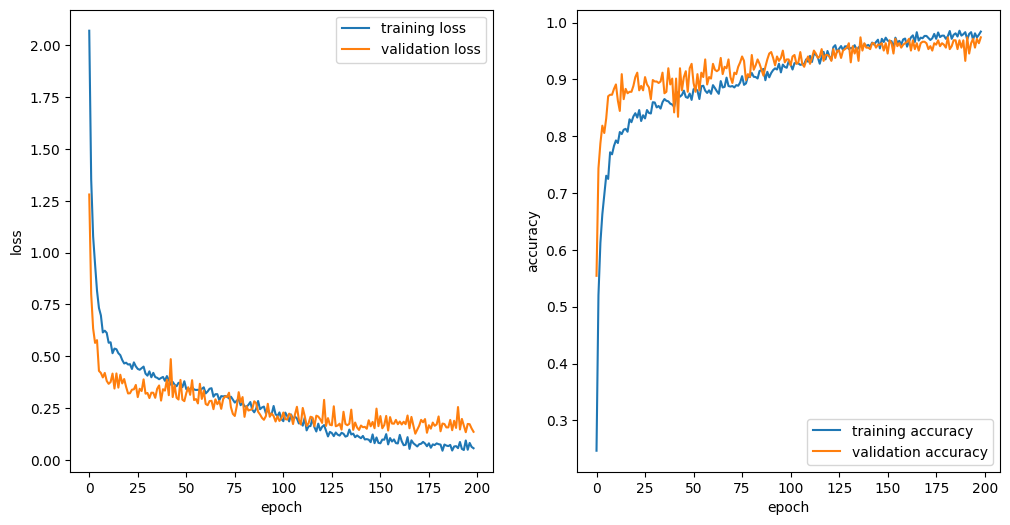

In [ ]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

Now retrain on training + validation and save the model.

In [ ]:
model2 = Sequential()
model2.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences = False))
model2.add(Dropout(0.2))
model2.add(Dense(32))
model2.add(Dropout(0.2))
model2.add(Dense(12, activation = 'softmax'))

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model2.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history2 = model2.fit(X, y, epochs = 175, batch_size = 16)

Epoch 1/175
219/219 [==============================] - 8s 9ms/step - loss: 1.8687 - accuracy: 0.3041
Epoch 2/175
219/219 [==============================] - 2s 9ms/step - loss: 1.1356 - accuracy: 0.5745
Epoch 3/175
219/219 [==============================] - 2s 9ms/step - loss: 0.9192 - accuracy: 0.6528
Epoch 4/175
219/219 [==============================] - 2s 9ms/step - loss: 0.7876 - accuracy: 0.7039
Epoch 5/175
219/219 [==============================] - 3s 13ms/step - loss: 0.7167 - accuracy: 0.7219
Epoch 6/175
219/219 [==============================] - 5s 23ms/step - loss: 0.6527 - accuracy: 0.7547
Epoch 7/175
219/219 [==============================] - 3s 14ms/step - loss: 0.6388 - accuracy: 0.7624
Epoch 8/175
219/219 [==============================] - 2s 9ms/step - loss: 0.5971 - accuracy: 0.7867
Epoch 9/175
219/219 [==============================] - 2s 9ms/step - loss: 0.6026 - accuracy: 0.7718
Epoch 10/175
219/219 [==============================] - 2s 11ms/step - loss: 0.5556 - ac

In [ ]:
model2.save('/content/gdrive/MyDrive/DSLSC//Models_3/Model2_5.h5')

Let's try this model.

### Keras tuner \#3

In [ ]:
#!rm -rf /content/best_hyperparams_3

Now we use the keras tuner in order to find the best regularizers combination.

In [ ]:
# 64 different combinations
def build_model_3(hp):
  model = Sequential()
  model.add(LSTM(units = 32, input_shape = (seq_len, n_feats), return_sequences = True, 
                 kernel_regularizer = regularizers.l2(hp.Choice('kernel_regularizer_lstm_1', values = [0.0, 0.01])),
                 bias_regularizer = regularizers.l2(hp.Choice('bias_regularizer_lstm_1', values = [0.0, 0.01]))))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 64, return_sequences = False,
                 kernel_regularizer = regularizers.l2(hp.Choice('kernel_regularizer_lstm_2', values = [0.0, 0.01])),
                 bias_regularizer = regularizers.l2(hp.Choice('bias_regularizer_lstm_2', values = [0.0, 0.01]))))
  model.add(Dropout(0.2))
  model.add(Dense(units = 32,
                  kernel_regularizer = regularizers.l2(hp.Choice('kernel_regularizer_dense', values = [0.0, 0.01])),
                  bias_regularizer = regularizers.l2(hp.Choice('bias_regularizer_dense', values = [0.0, 0.01]))))
  model.add(Dropout(0.2))
  model.add(Dense(12, activation = 'softmax'))
  
  optimizer = Adam(learning_rate = 0.001)
  model.compile(optimizer =  optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
tuner_3 = GridSearch(
  build_model_3,
  objective = 'val_loss',
  executions_per_trial = 1,
  directory = '/content',
  project_name = 'best_hyperparams_3'
)

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
# Grid search
tuner_3.search(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_val, y_val), callbacks = [stop_early])

In [ ]:
# Retrieve best hyperparameters and final model
best_hp = tuner_3.get_best_hyperparameters()[0]
best_model = tuner_3.hypermodel.build(best_hp)

In [ ]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 32)             4864      
                                                                 
 dropout_3 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 12)               

Let's try this model.

### Model 3

In [ ]:
model3 = Sequential()
model3.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True, bias_regularizer = regularizers.l2(0.01)))
model3.add(Dropout(0.2))
model3.add(LSTM(64, return_sequences = False))
model3.add(Dropout(0.2))
model3.add(Dense(32))
model3.add(Dropout(0.2))
model3.add(Dense(12, activation = 'softmax'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 32)             4864      
                                                                 
 dropout_6 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 12)               

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model3.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history3 = model3.fit(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_val, y_val), callbacks = [stop_early])

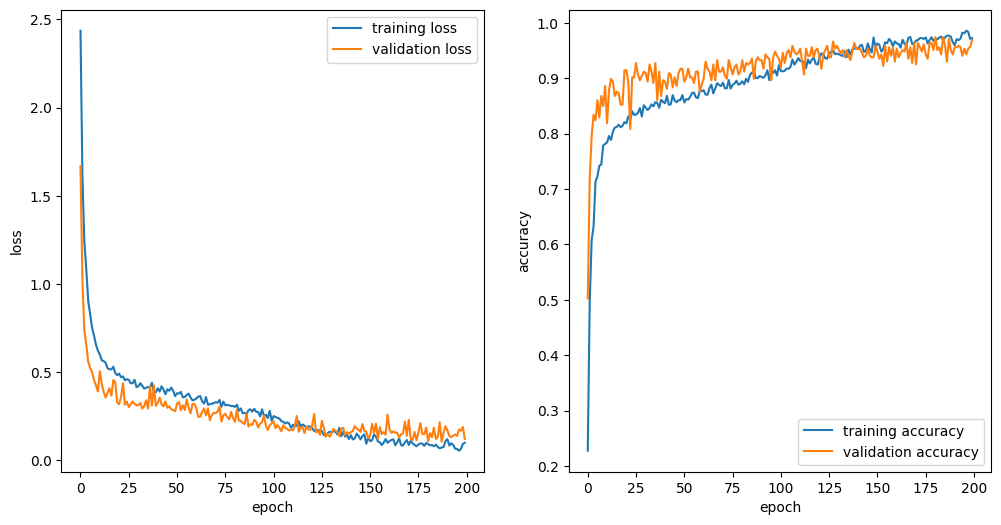

In [ ]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

Now retrain on training + validation and save the model.

In [ ]:
model3 = Sequential()
model3.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True, bias_regularizer = regularizers.l2(0.01)))
model3.add(Dropout(0.2))
model3.add(LSTM(64, return_sequences = False))
model3.add(Dropout(0.2))
model3.add(Dense(32))
model3.add(Dropout(0.2))
model3.add(Dense(12, activation = 'softmax'))

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model3.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history3 = model3.fit(X, y, epochs = 200, batch_size = 16)

Epoch 1/200
219/219 [==============================] - 13s 9ms/step - loss: 2.0033 - accuracy: 0.3638
Epoch 2/200
219/219 [==============================] - 2s 9ms/step - loss: 1.2053 - accuracy: 0.6077
Epoch 3/200
219/219 [==============================] - 2s 9ms/step - loss: 0.9145 - accuracy: 0.6930
Epoch 4/200
219/219 [==============================] - 2s 9ms/step - loss: 0.7774 - accuracy: 0.7356
Epoch 5/200
219/219 [==============================] - 3s 13ms/step - loss: 0.6946 - accuracy: 0.7510
Epoch 6/200
219/219 [==============================] - 3s 12ms/step - loss: 0.6544 - accuracy: 0.7641
Epoch 7/200
219/219 [==============================] - 2s 9ms/step - loss: 0.6290 - accuracy: 0.7724
Epoch 8/200
219/219 [==============================] - 2s 9ms/step - loss: 0.5861 - accuracy: 0.7878
Epoch 9/200
219/219 [==============================] - 2s 9ms/step - loss: 0.5788 - accuracy: 0.7927
Epoch 10/200
219/219 [==============================] - 2s 9ms/step - loss: 0.5685 - acc

In [ ]:
model3.save('/content/gdrive/MyDrive/DSLSC//Models_3/Model3_5.h5')

### Model 4

Now we may try increasing the batch_size to 32.

In [ ]:
model4 = Sequential()
model4.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True, bias_regularizer = regularizers.l2(0.01)))
model4.add(Dropout(0.2))
model4.add(LSTM(64, return_sequences = False))
model4.add(Dropout(0.2))
model4.add(Dense(32))
model4.add(Dropout(0.2))
model4.add(Dense(12, activation = 'softmax'))
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 5, 32)             4864      
                                                                 
 dropout_12 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 12)               

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model4.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history4 = model4.fit(X_train, y_train, epochs = 200, batch_size = 32, validation_data = (X_val, y_val), callbacks = [stop_early])

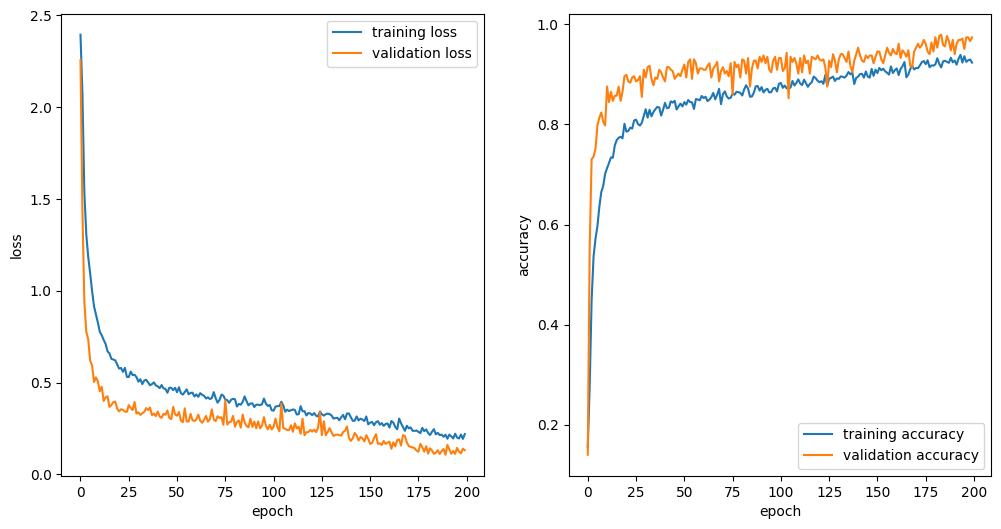

In [ ]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

Now retrain on training + validation and save the model.

In [ ]:
model4 = Sequential()
model4.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True, bias_regularizer = regularizers.l2(0.01)))
model4.add(Dropout(0.2))
model4.add(LSTM(64, return_sequences = False))
model4.add(Dropout(0.2))
model4.add(Dense(32))
model4.add(Dropout(0.2))
model4.add(Dense(12, activation = 'softmax'))

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model4.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history4 = model4.fit(X, y, epochs = 250, batch_size = 32)

Epoch 1/250
110/110 [==============================] - 6s 13ms/step - loss: 2.4338 - accuracy: 0.2113
Epoch 2/250
110/110 [==============================] - 1s 10ms/step - loss: 1.6576 - accuracy: 0.4643
Epoch 3/250
110/110 [==============================] - 1s 10ms/step - loss: 1.2420 - accuracy: 0.6019
Epoch 4/250
110/110 [==============================] - 1s 10ms/step - loss: 1.0324 - accuracy: 0.6585
Epoch 5/250
110/110 [==============================] - 1s 10ms/step - loss: 0.9112 - accuracy: 0.6979
Epoch 6/250
110/110 [==============================] - 1s 10ms/step - loss: 0.8232 - accuracy: 0.7187
Epoch 7/250
110/110 [==============================] - 1s 10ms/step - loss: 0.7480 - accuracy: 0.7487
Epoch 8/250
110/110 [==============================] - 1s 10ms/step - loss: 0.7043 - accuracy: 0.7513
Epoch 9/250
110/110 [==============================] - 2s 17ms/step - loss: 0.6881 - accuracy: 0.7536
Epoch 10/250
110/110 [==============================] - 3s 23ms/step - loss: 0.653

In [ ]:
model4.save('/content/gdrive/MyDrive/DSLSC//Models_3/Model4_5.h5')

## Testing

Finally, we load our models in order to evaluate them on the test-set.

### Model 0

In [ ]:
model0 = load_model('/content/gdrive/MyDrive/DSLSC/Models_3/Model0_5.h5')

In [ ]:
y_pred = model0.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

13/13 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.81      0.89        26
           1       0.96      0.93      0.94        27
           2       0.95      0.97      0.96        36
           3       0.79      1.00      0.88        22
           4       0.75      0.86      0.80        14
           5       1.00      0.65      0.79        20
           6       0.98      0.96      0.97        51
           7       0.89      0.98      0.94        52
           8       0.87      0.98      0.92        41
           9       0.96      1.00      0.98        46
          10       1.00      0.84      0.92        32
          11       0.96      0.88      0.92        25

    accuracy                           0.93       392
   macro avg       0.93      0.90      0.91       392
weighted avg       0.93      0.93      0.93       392



Text(0, 0.5, 'Prediction')

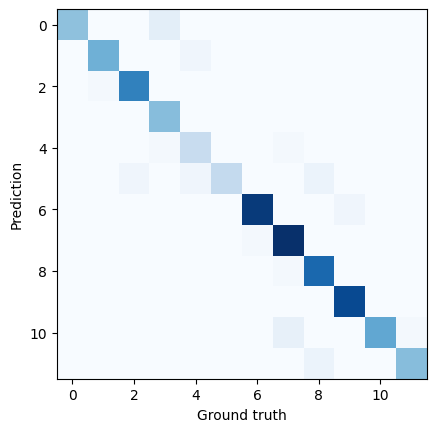

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.9948979591836735
0.9974489795918368


### Model 1

In [ ]:
model1 = load_model('/content/gdrive/MyDrive/DSLSC/Models_3/Model1_5.h5')

In [ ]:
y_pred = model1.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

13/13 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       0.96      0.96      0.96        27
           2       0.97      0.97      0.97        36
           3       1.00      1.00      1.00        22
           4       0.93      0.93      0.93        14
           5       0.95      0.90      0.92        20
           6       1.00      0.88      0.94        51
           7       0.90      1.00      0.95        52
           8       1.00      0.95      0.97        41
           9       0.98      0.98      0.98        46
          10       0.97      0.97      0.97        32
          11       0.96      1.00      0.98        25

    accuracy                           0.96       392
   macro avg       0.96      0.96      0.96       392
weighted avg       0.96      0.96      0.96       392



Text(0, 0.5, 'Prediction')

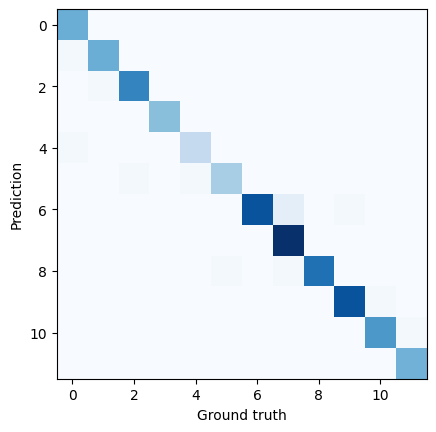

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.9974489795918368
0.9974489795918368


### Model 2

In [ ]:
model2 = load_model('/content/gdrive/MyDrive/DSLSC/Models_3/Model2_5.h5')

In [ ]:
y_pred = model2.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

13/13 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        26
           1       1.00      0.89      0.94        27
           2       0.97      1.00      0.99        36
           3       0.76      1.00      0.86        22
           4       0.76      0.93      0.84        14
           5       1.00      0.85      0.92        20
           6       1.00      1.00      1.00        51
           7       0.98      1.00      0.99        52
           8       0.98      0.98      0.98        41
           9       1.00      1.00      1.00        46
          10       1.00      1.00      1.00        32
          11       1.00      1.00      1.00        25

    accuracy                           0.96       392
   macro avg       0.95      0.95      0.95       392
weighted avg       0.97      0.96      0.96       392



Text(0, 0.5, 'Prediction')

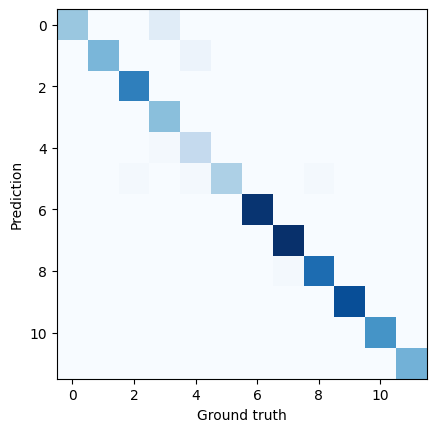

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.9948979591836735
0.9974489795918368


### Model 3

In [ ]:
model3 = load_model('/content/gdrive/MyDrive/DSLSC/Models_3/Model3_5.h5')

In [ ]:
y_pred = model3.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

13/13 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        26
           1       1.00      1.00      1.00        27
           2       0.97      1.00      0.99        36
           3       0.81      1.00      0.90        22
           4       0.93      0.93      0.93        14
           5       1.00      0.90      0.95        20
           6       1.00      0.98      0.99        51
           7       1.00      1.00      1.00        52
           8       1.00      1.00      1.00        41
           9       0.98      1.00      0.99        46
          10       1.00      1.00      1.00        32
          11       1.00      1.00      1.00        25

    accuracy                           0.98       392
   macro avg       0.97      0.97      0.97       392
weighted avg       0.98      0.98      0.98       392



Text(0, 0.5, 'Prediction')

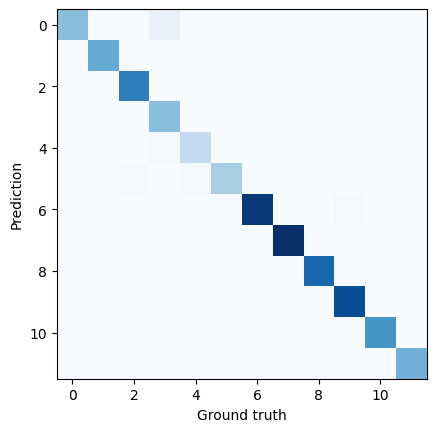

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.9948979591836735
0.9974489795918368


### Model 4

In [ ]:
model4 = load_model('/content/gdrive/MyDrive/DSLSC/Models_3/Model4_5.h5')

In [ ]:
y_pred = model4.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

13/13 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       1.00      1.00      1.00        27
           2       0.97      1.00      0.99        36
           3       0.92      1.00      0.96        22
           4       0.93      0.93      0.93        14
           5       1.00      0.90      0.95        20
           6       1.00      1.00      1.00        51
           7       0.98      1.00      0.99        52
           8       1.00      0.98      0.99        41
           9       1.00      1.00      1.00        46
          10       1.00      1.00      1.00        32
          11       1.00      1.00      1.00        25

    accuracy                           0.99       392
   macro avg       0.98      0.98      0.98       392
weighted avg       0.99      0.99      0.99       392



Text(0, 0.5, 'Prediction')

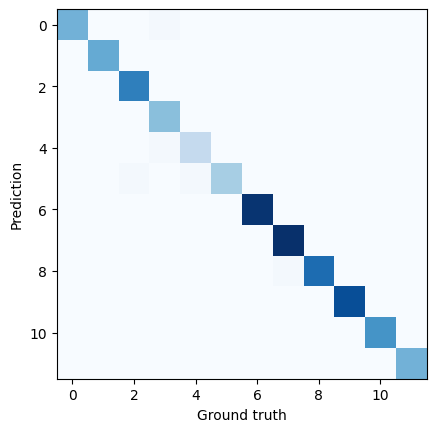

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.9948979591836735
0.9974489795918368
